# CHB: 1. Image Classification Model

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.regularizers as tfr
import tensorflow.keras.metrics as tfm
import tensorflow_addons as tfa

import numpy as np

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
from PIL import Image
import imghdr


from itertools import islice

import pathlib
import os

In [2]:
# what's the version of your TensorFlow
print(tf.__version__)

# check whether you have a TF compatible GPU
tf.config.experimental.list_physical_devices('GPU')

2.9.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# fix the MEM error (which says GPU MEM is full)
gpus = tf.config.list_physical_devices('GPU')

# to set memory growth limit for each GPU (if have more than one)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Define Custom Funcs

### Funcs for Plotting

In [4]:
# define matplotlib, seaborn configs

# mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metrics:list):
  '''
  args:
      history: the output of model.fit()
  
  returns:
      a multi plot of the performance of the model
  '''
  plt.figure(figsize=(12, 10))
  # take the ceiling of #metrics provided as the #rows
  plot_height = int(len(metrics) / 2) + 1

  for i, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(plot_height,2,i+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.tight_layout();
  

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

## Create Dataset
> from images

### for binary classification
> class 0: Need Restoration, class 1: No Need Restoration

In [5]:
# define the dir (containing the pics)

# method 1 (caveman): use only os.path (don't use as the following cells need pathlib.Path)
# data_dir = os.path.join(image_dir, 'data', '')

# method 2 (sophi): use pathlib (has many facilites)
# data_dir = pathlib.Path(os.path.join('data', ''))
# data_dir = pathlib.Path('/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/1. Image Classification')
data_dir = pathlib.Path(os.path.join('..', '..', '..', '..', '..','Thesis Data', 'Pix', '0 Model Ready Data', '1. Image Classification', ''))
print('data_dir:', data_dir)

data_dir: ../../../../../Thesis Data/Pix/0 Model Ready Data/1. Image Classification


In [6]:
jpg_image_count = len(list(data_dir.glob('*/*.jpg')))
JPG_image_count = len(list(data_dir.glob('*/*.JPG')))
jpeg_image_count = len(list(data_dir.glob('*/*.jpeg')))
png_image_count = len(list(data_dir.glob('*/*.png')))
PNG_image_count = len(list(data_dir.glob('*/*.PNG')))

print('jpg image_count:', jpg_image_count)
print('JPG image_count:', JPG_image_count)
print('jpeg image_count:', jpeg_image_count)
print('png image_count:', png_image_count)

print(f'total images in data dir:', (jpg_image_count + JPG_image_count + jpeg_image_count + png_image_count))
print(f'total files in data dir:', len(list(data_dir.glob('*/*'))))

jpg image_count: 536
JPG image_count: 828
jpeg image_count: 343
png image_count: 19
total images in data dir: 1726
total files in data dir: 1727


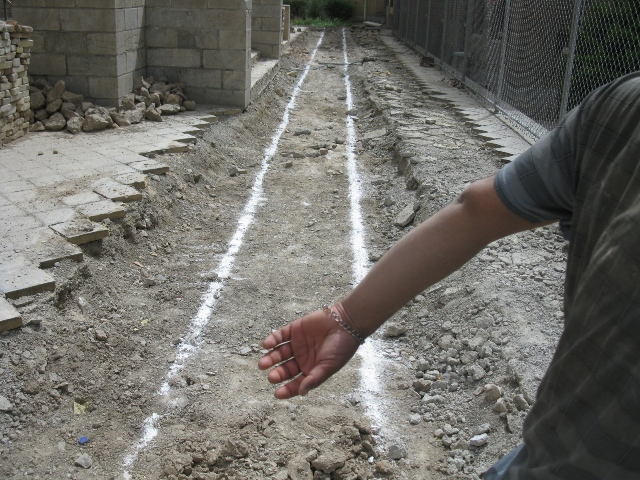

In [7]:
# show an image from a desired class (before creating a dataset & resizing)

label = 'YES'  # define the desired class/label
class_imgs_paths = list(data_dir.glob(f'*{label}*/*'))  # get all img_paths in the desired label dir
rand_index = np.random.randint(low=0, high=len(class_imgs_paths))  # take a random index

# if the filepaths were not string use Image.open(str(filepath))
an_img = Image.open(class_imgs_paths[rand_index])  # open/import the image (like plt.imread())
display(an_img)  # display the image (like plt.imshow())

In [8]:
# Check for files that are not image , or that are not what their extension says they are
# to avoid futere bugs/erros

import imghdr

supported_types = ["bmp", "gif", "jpeg", "png"]  # the image types supported by TF

# # method 1 (stackoverflow)
# img_extensions = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions (existent in data_dir)
# not_img = []  # to be filled with files that are not img
# not_supported_by_tf = []  # to be filled with unsupported img files (by TF)

# for filepath in pathlib.Path(data_dir).rglob("*"):  # get all the files in the 'data_dir'
#     if filepath.suffix.lower() in img_extensions:  # check if the file has one the provided img_extensions
#         img_type = imghdr.what(filepath)  # get the file's type
#         if img_type is None:  # if the file was not an img
#             not_img.append(filepath)
#             print(f"{filepath} is not an image")
#         elif img_type not in supported_types:  # if the file is an img but not supported by TF
#             not_supported_by_tf.append(filepath)
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
# print('-'*79)

# method 2 (tekboart): doesn't need us to define file extensions in data_dir (namely var img_extensions)
# so this method check all files (not just the provided extentions)
not_img = []  # to be filled with files that are not img
not_supported_by_tf = []  # to be filled with unsupported img files (by TF)

for filepath in pathlib.Path(data_dir).rglob("*"):  # get all the files in the 'data_dir'
    if filepath.suffix.lower().startswith('.'):  # check if filepath is a file (not a dir)
        img_type = imghdr.what(filepath)  # get the file's type
        if img_type is None:  # if the file was not an img
            not_img.append(filepath)
            print(f"{filepath} is not an image")
        elif img_type not in supported_types:  # if the file is an img but not supported by TF
            not_supported_by_tf.append(filepath)
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

print('-'*79)

# remove these files from dirs (permanently)
filepaths_to_rm = [*not_img, *not_supported_by_tf]
print('#files to be removed:', len(filepaths_to_rm))

for filepath in filepaths_to_rm:
    print("removed", filepath)
    # os.remove(filepath)  # uncomment only if you are sure about the removal

-------------------------------------------------------------------------------
#files to be removed: 0


In [9]:
# define the batch_size
# this is important to ensure that each batch has a decent chance of containing a few inferior label samples (i.e., NO restoration label). 
# If the batch size was too small, they would likely have no inferior label samples to learn from.
batch_size = 32

# define the image size (after resizing)
# input_shape = (64, 64, 3)
input_shape = (150, 150, 3)
# input_shape = (250, 250, 3)

print('\033[92m creating train set \033[0m'.center(79, '-'))
# must use the same seed for train, val, test sets, otherwise they might overlap (as the process becomes random)
train_ds_orig = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    label_mode='int',
    class_names=['NO restoration', 'YES restoration'],
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(input_shape[0], input_shape[1]),
    crop_to_aspect_ratio=False,
    shuffle=True,  # default True
    batch_size=batch_size)  # default 32

print('\033[91m creating val set \033[0m'.center(79, '-'))
val_ds_orig = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    label_mode='int',
    class_names=['NO restoration', 'YES restoration'],
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(input_shape[0], input_shape[1]),
    crop_to_aspect_ratio=False,
    shuffle=True,
    batch_size=batch_size)


------------------------- creating train set -------------------------
Found 1736 files belonging to 2 classes.
Using 1389 files for training.
-------------------------- creating val set --------------------------
Found 1736 files belonging to 2 classes.
Using 347 files for validation.


In [10]:
# method 1 (slow)
# num_classes = len({label.numpy() for elem in train_ds_orig for label in elem[1]})
# method 2 (fast): works only with datasets created with keras.utils
num_classes = len(train_ds_orig.class_names)
print(dict(zip(train_ds_orig.class_names, range(num_classes))), end="\n\n")

# Give weights to diff classes
train_label_no = sum(np.sum(elem[1].numpy() == 0) for elem in train_ds_orig)
train_label_yes = sum(np.sum(elem[1].numpy() == 1) for elem in train_ds_orig)

val_label_no = sum(np.sum(elem[1].numpy() == 0) for elem in val_ds_orig)
val_label_yes = sum(np.sum(elem[1].numpy() == 1) for elem in val_ds_orig)

neg = train_label_no + val_label_no
pos = train_label_yes + val_label_yes
total = neg + pos

print(f'Examples:\n    Total: {total}\n    label 0 (Negative): {neg} ({(neg / total)*100:.2f}% of total)\n    label 1 (Positive): {pos} ({(pos / total)*100:.2f}% of total)\n')


# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / num_classes)
weight_for_1 = (1 / pos) * (total / num_classes)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

{'NO restoration': 0, 'YES restoration': 1}

Examples:
    Total: 1736
    label 0 (Negative): 631 (36.35% of total)
    label 1 (Positive): 1105 (63.65% of total)

Weight for class 0: 1.38
Weight for class 1: 0.79


In [11]:
# Check the resulting dataset shapes
# shows None (in shapes) if the #elsms in the last mini_batch < batch_size
print('each elem\'s images shape:', train_ds_orig.element_spec[0].shape)
print('each elem\'s labels shape:', train_ds_orig.element_spec[1].shape)

print('.'*79)

# method 2 (sophi): doesn't show None in shapes
images_batch, labels_batch = next(iter(train_ds_orig))
print('each elem\'s images shape:', images_batch.shape)
print('each elem\'s labels shape:', labels_batch.shape)

# # could use a for-loop too (TF documentation) (but caveman)
# for images_batch, labels_batch in train_ds:
#     print('each elem\'s images shape:', images_batch.shape)
#     print('each elem\'s labels shape:', labels_batch.shape)
#     break

print('-'*79)

# print the labels/classes
class_names = train_ds_orig.class_names
print("the classes/labels:", class_names)

each elem's images shape: (None, 150, 150, 3)
each elem's labels shape: (None,)
...............................................................................
each elem's images shape: (32, 150, 150, 3)
each elem's labels shape: (32,)
-------------------------------------------------------------------------------
the classes/labels: ['NO restoration', 'YES restoration']


##### Visualize the created img datasets

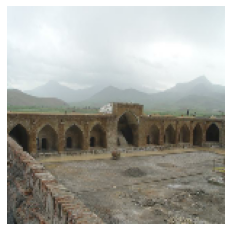

In [12]:
# take a single image from a mini_batch (in train_ds)
# i.e., the 1st img from the first batch
an_img = next(iter(train_ds_orig))[0][0]

plt.imshow(an_img.numpy().astype('uint8'))
plt.axis('off')
plt.show()

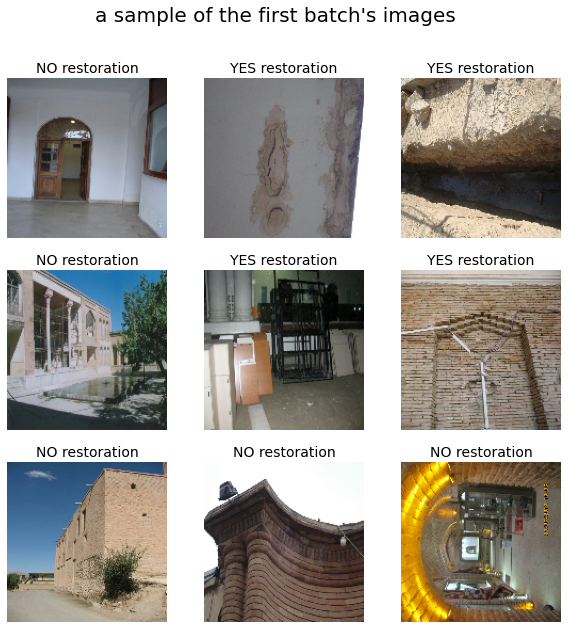

In [13]:
# Show some sample images
class_names = train_ds_orig.class_names

# method 2 (tekboart): no for-loop
plt.figure(figsize=(10, 10))

images, labels = next(iter(train_ds_orig))  # take a mini_batch (i.e., a tuple) and unpack it (images_batch, labels_batch)
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]], fontsize=14)
  plt.axis("off")
plt.suptitle('a sample of the first batch\'s images', fontsize=20)
plt.show()

## Pre-Process data

### Normalization

In [14]:
# normalize
train_ds_norm = train_ds_orig.map(lambda x, y: (tf.cast(x, tf.float32)/255., y))
val_ds_norm = val_ds_orig.map(lambda x, y: (tf.cast(x, tf.float32)/255., y))

# Check whether all pixel values are within [0, 1]
max_ = np.max(next(iter(train_ds_norm))[0].numpy())
min_ = np.min(next(iter(train_ds_norm))[0].numpy())
print(f'max: {max_}, min: {min_}')

max: 1.0, min: 0.0


### One-hot encoding
> No need, since we are doing binary classification

In [15]:
# train_ds_hot = train_ds_norm.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
# val_ds_hot = val_ds_norm.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

# print('train set labels shape:', train_ds_hot.element_spec[1].shape)
# print('val set labels shape:', val_ds_hot.element_spec[1].shape)

### Configure the dataset for performance
> now after this step your datasets are ready to be used in a Keras model 

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_norm.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)

## data augmentation

### data augmentation (in pure TF)
> in pure TF so not suitable with working with Keras models, as the batch_size 'None' will not work with it

> to use it we either use it in dataset.map() func or in a data pipeline

> in contrast to Keras data augmentation methods we need to somehow turn of the data_augmentation_tf during evaluate or predict time

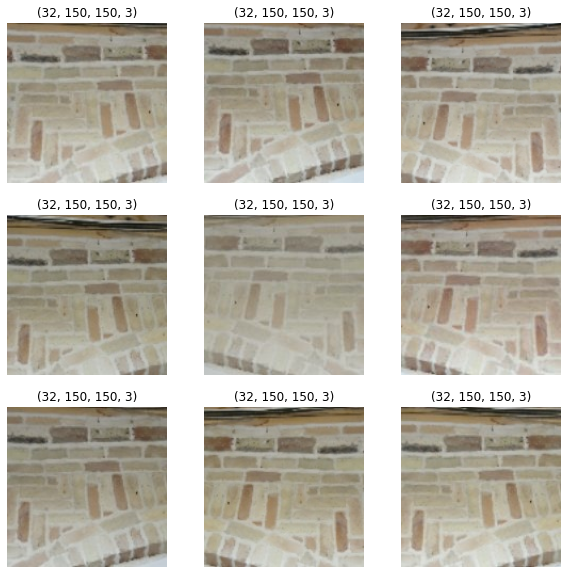

In [17]:
# method 2: using a func (inside can use both TF_funcs & keras_layers)
def data_augmentation_tf(img):
  '''
  args:
    img: An image as a rank-4 tensor (NHWC)
    input_shape: a tuple (H, W, C)
    batch_size: the number of images in each batch
  returns:
    x: an augmented image tensor (with the same shape as input img)
  '''
  x = img

  # step 1: augment the color, brightness, contrast, saturation
  x = tf.image.random_brightness(x, max_delta=.05)
  x = tf.image.random_contrast(x, lower=.6, upper=1.2)
  x = tf.image.random_saturation(x, 0.75, 1.1)
  x = tf.image.random_hue(x, 0.02)
  
  # step 2: flip, crop, resize, center, change quality of the img
  # x = tf.image.flip_left_right(x)  # don't know why the tf.image ver doesn't work
  x = tfl.RandomFlip("horizontal")(x)

  input_shape = img.shape
  crop_ratio = 0.9  # means keep 90% of the img (or crop 10% of img)
  if len(input_shape) == 3:
    H = input_shape[0]
    W = input_shape[1]
    C = input_shape[2]
    crop_H = int(H * crop_ratio)
    crop_W = int(W * crop_ratio)
    # do random crop
    x = tf.image.random_crop(x, size=(crop_H, crop_W, C))
    # resize and center the cropped image (as we changed the img size & center by random crop)
    num_cropped_pixels_H = H - crop_H
    num_cropped_pixels_W = W - crop_W
    # use 2* because i.e., in height we cropped some pixels (e.g., 16) from both top & bottom (hence a total of 2*16=32 pixels were cropped)
    x = tf.image.resize(x, ((H+2*num_cropped_pixels_H), (W+2*num_cropped_pixels_W)))
    x = x[num_cropped_pixels_H:-num_cropped_pixels_H, num_cropped_pixels_W:-num_cropped_pixels_W, :]
    # Randomly change jpeg encoding quality for inducing jpeg noise.
    x = tf.image.random_jpeg_quality(x, 75, 95)
  elif len(input_shape) == 4:
    N = input_shape[0]
    H = input_shape[1]
    W = input_shape[2]
    C = input_shape[3]
    crop_H = int(H * crop_ratio)
    crop_W = int(W * crop_ratio)
    x = tf.image.random_crop(x, size=(N, crop_H, crop_W, C))
    # resize and center the cropped image (as we changed the img size & center by random crop)
    num_cropped_pixels_H = H - crop_H
    num_cropped_pixels_W = W - crop_W
    # use 2* because i.e., in height we cropped some pixels (e.g., 16) from both top & bottom (hence a total of 2*16=32 pixels were cropped)
    x = tf.image.resize(x, ((H+2*num_cropped_pixels_H), (W+2*num_cropped_pixels_W)))
    x = x[:, num_cropped_pixels_H:-num_cropped_pixels_H, num_cropped_pixels_W:-num_cropped_pixels_W, :]

    # Randomly change jpeg encoding quality for inducing jpeg noise.
    x_new = tf.zeros([1, H, W, C], dtype=tf.float32)
    for i in range(N):
      img_ch_quality = tf.image.random_jpeg_quality(x[i], 80, 100)
      x_new = tf.concat([x_new, tf.expand_dims(img_ch_quality, 0)], axis=0)
    x = x_new[1:]

  return x

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = np.array(Image.open(grace_hopper).resize((input_shape[0], input_shape[1]))).astype(np.float32)/255.
images = np.expand_dims(grace_hopper, axis=0)
# plt.imshow(image[0])

images = next(iter(train_ds))[0]

# plt.imshow(tfl.RandomFlip('horizontal')(image)[0])

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_images = data_augmentation_tf(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0])
  plt.title(augmented_images.shape)
  plt.axis("off")

### data augmentation (in Keras)

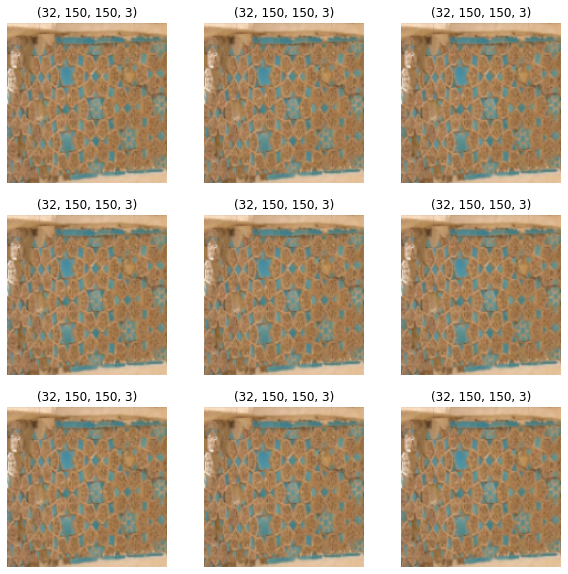

In [26]:
# method 1: using Keras Seq model
# using Keras for Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).
data_augmentation_keras = tf.keras.Sequential([
        tfl.RandomContrast(.6, 1.2),
        tfl.RandomFlip("horizontal"),
        # tfl.RandomTranslation(.1, .1),
        # tfl.RandomZoom(0.9),
        # tfl.RandomRotation(0.1),
        tfl.RandomCrop(int(input_shape[0]*.9), int(input_shape[1]*.9)),
        # tf.keras.layers.CenterCrop(int(input_shape[0]*.9), int(input_shape[1]*.9)),  # not so good as it's deterministic for the same H, W
        tfl.Resizing(input_shape[0], input_shape[1])
    ])

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = np.array(Image.open(grace_hopper).resize((input_shape[0], input_shape[1]))).astype(np.float32)/255.
images = np.expand_dims(grace_hopper, axis=0)
# plt.imshow(image[0])

images = next(iter(train_ds))[0]

# plt.imshow(tfl.RandomFlip('horizontal')(image)[0])

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_images = data_augmentation_keras(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0])
  plt.title(augmented_images.shape)
  plt.axis("off")

## Create Model

### ResNet50

#### 1. Create a ResNet50 from scratch (with Functional API)

##### Create an IdentityBlock (with Functional API)
> Identity Block is a ResBlock in which the result of "main path" and the input (of main math) have the same shape

In [ ]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, training=True, drop_prob=0, lambda_=0):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    # X = tfl.Dropout(drop_prob)(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = tfl.Conv2D(filters= F2, kernel_size=f, padding='same', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    # X = tfl.Dropout(drop_prob)(X)

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = tfl.Conv2D(filters= F3, kernel_size=1, kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training = training) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    # X = tfl.Dropout(drop_prob)(X)
    ### END CODE HERE

    return X

##### Create an Convolutional Block (with Functional API)
> Convolutional Block is a ResBlock in which the result of "main path" and the input (of main math) have the same shape

> I think this Convolution Block is the same as a Bottleneck Block (in MobileNet v2)

In [ ]:

# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, drop_prob=0, lambda_=0):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    # X = tfl.Dropout(drop_prob)(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    # X = tfl.Dropout(drop_prob)(X)

    ## Third component of main path (≈2 lines)
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_regularizer=tfr.l2(lambda_))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    # X = tfl.Dropout(drop_prob)(X)
    
    return X

##### Create the Final ResNet50

In [ ]:

# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6, drop_prob=0, l2_lambda=0):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = tf.keras.Input(input_shape)
    X = X_input

    # add data augmentation
    X = data_augmentation(X)

    # Zero-Padding
    X = tfl.ZeroPadding2D((3, 3))(X)
    
    # Stage 1
    X = tfl.Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [64, 64, 256], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [64, 64, 256], drop_prob=drop_prob, lambda_=l2_lambda)

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [128, 128, 512], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [128, 128, 512], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [128, 128, 512], drop_prob=drop_prob, lambda_=l2_lambda)
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [512, 512, 2048], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [512, 512, 2048], drop_prob=drop_prob, lambda_=l2_lambda)

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = tfl.AveragePooling2D(pool_size=(2, 2))(X)
    
    ### END CODE HERE


    # Classification phase
    X = tfl.Flatten()(X)
    X = tfl.Dropout(drop_prob)(X)

    # # FC1
    # X = tfl.Dense(1000)(X)
    # X = tfl.BatchNormalization(axis=1)(X)
    # X = tfl.ReLU()(X)

    # # FC2
    # X = tfl.Dense(500)(X)
    # X = tfl.BatchNormalization(axis=1)(X)
    # X = tfl.ReLU()(X)

    # X = tfl.Dense(classes, activation='softmax')(X)  # for multi-class classification
    X = tfl.Dense(1, activation='sigmoid')(X)  # for binary classification
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X)

    return model

##### Modifty the Final ResNet50 (from scratch)
> by adding preprocessing, data augmentation, output layer, regularization, etc.

In [ ]:
# def my_model(a_keras_model, input_shape, classes=num_classes, drop_prob=0, l2_lambda=0):
#     inputs = tf.keras.Input(shape=input_shape)
#     X = inputs

#     X = a_keras_model(X, input_shape, classes=num_classes, drop_prob=0, l2_lambda=0)

#     X = tfl.Dense(num_classes)
#     X = tfl.Flatten()(X)
#     X = tfl.Dropout(drop_prob)(X)

#     outputs = X


#     model = tf.keras.Model(inputs, outputs)
#     return model

##### instantiate a ResNet50 model

In [ ]:
ResNet50_scratch = ResNet50(input_shape=input_shape, classes=num_classes, drop_prob=0, l2_lambda=0)

print(ResNet50_scratch.summary())
# tf.keras.utils.plot_model(ResNet50_scratch)

##### Train the ResNet50

In [ ]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss',  # for multi-class classification
    monitor='val_prc',  # for binary classification
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
# # simple metrics
# metrics = ['accuracy']

# metrics for binary classification
metrics = [
    tfm.BinaryAccuracy(name='accuracy'),
    tfm.Precision(name='precision'),
    tfm.Recall(name='recall'),
    tfm.AUC(name='auc'),
    tfm.AUC(name='prc', curve='PR'),  # precision-recall curve
    tfm.TruePositives(name='tp'),
    tfm.FalsePositives(name='fp'),
    tfm.TrueNegatives(name='tn'),
    tfm.FalseNegatives(name='fn'),
]

# set LR_decay method
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

ResNet50_scratch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                         metrics=metrics)

epochs = 20

ResNet50_scratch_history = ResNet50_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    # class_weight=None)
    class_weight=class_weight)


##### Plot the training performance

In [ ]:
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
plot_metrics(ResNet50_scratch_history, metrics=metrics_names)
plt.show()

In [ ]:
# !!! must use test instead of val

val_predictions_baseline = ResNet50_scratch.predict(val_ds)
print(val_predictions_baseline.shape)

baseline_results = ResNet50_scratch.evaluate(val_ds, verbose=0)

for name, value in zip(ResNet50_scratch.metrics_names, baseline_results):
  print(name, ': ', value)
print()

# for binary classification
y_true = [elem[1].numpy() for elem in val_ds.unbatch()]
# print(y_true)
y_pred = val_predictions_baseline
# print(y_pred)

# for multi-class classification
# y_true = [tf.argmax(elem[1]).numpy() for elem in val_ds.unbatch()]
# # print(y_true)
# y_pred = tf.argmax(val_predictions_baseline, axis=1).numpy()
# # print(y_pred)

plot_cm(y_true, y_pred)

##### Test the ResNet50 (from scratch)

In [ ]:
preds_scratch = ResNet50_scratch.evaluate(val_ds, verbose=0)

print ("Test Loss = " + str(preds_scratch[0]))
print ("Test Accuracy = " + str(preds_scratch[1]))

##### predict with the ResNet50 (from scratch)

In [ ]:
# define the resize_shape
shape = ResNet50_scratch.input_shape
resize_shape = (shape[1], shape[2])

# define image address
# addr = '/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/76.JPG'
addr = "F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\IMG_6669.JPG"

# prepare an img to be given to the model as input
img_file = Image.open(addr)
img_file_resized = img_file.resize(resize_shape)  # resize the img to the model's input_shape
img_tensor = tf.constant(np.array(img_file_resized))  # PIL ImageFile to TF tensor
img_tensor_norm = tf.cast(img_tensor, tf.float32) / 255.
img_final = tf.expand_dims(img_tensor_norm, axis=0)  # convert (H, W, C) --> (1, H, W, C)
print('img_final shape:', img_final.shape)

# do the prediction (only forward pass)
inference = ResNet50_scratch.predict(img_final, verbose=0)

print('the inference:\n', inference.round(2), sep="")
label = tf.argmax(inference.squeeze()).numpy()  # used .squeeze() since the shape of inference is (1, C)
plt.imshow(img_tensor_norm.numpy())
plt.title(f'predicted label = {label}')
plt.show

#### 2. Load a pretrained ResNet50
> we just use a pretrained ResNet50 (trained with ImageNet) but not do transfer learning

In [23]:
# ResNet50_pretrained = tf.keras.models.load_model('/run/media/tekboart/SP 2TB/CE - CS/Development/Exercise/00 Resources/Models/resnet50.h5')
ResNet50v2_pretrained = tf.keras.applications.ResNet50V2(input_shape=input_shape, include_top=False, weights='imagenet')

In [24]:
def tl_model_builder(pretrained_model, input_shape, drop_prob=0):
    # freeze the classification phase layers (use them only for feature extraction)
    pretrained_model.trainable = False

    # build a model (on top of the base/pretrained model)
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    x = data_augmentation_keras(x)
    # x = preprocess_input(x)
    x = pretrained_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)  # to collapse the output of base/pretrained model
    x = tf.keras.layers.Dropout(drop_prob)(x)  # to add regularization
    # x = tfl.Dense(num_classes, activation='softmax')(x)  # for multi-class classification
    x = tfl.Dense(1, activation='sigmoid')(x)  # for binary classification
    outputs = x
    model = tf.keras.Model(inputs, outputs)

    return model

In [33]:
# instantiate a Transfer Learning Model
ResNet50v2_tl = tl_model_builder(ResNet50v2_pretrained, input_shape=input_shape, drop_prob=0)

In [34]:
# compile the model

# # simple metrics
# metrics = ['accuracy']

# metrics for binary classification
metrics = [
    tfm.BinaryAccuracy(name='accuracy'),
    tfm.Precision(name='precision'),
    tfm.Recall(name='recall'),
    tfm.AUC(name='auc'),
    tfm.AUC(name='prc', curve='PR'),  # precision-recall curve
    tfm.TruePositives(name='tp'),
    tfm.FalsePositives(name='fp'),
    tfm.TrueNegatives(name='tn'),
    tfm.FalseNegatives(name='fn'),
]

# set LR_decay method
base_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

ResNet50v2_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=metrics)

In [35]:
# check the performance of pretrained model (before training the added layers)
loss0, accuracy0, *_ = ResNet50v2_tl.evaluate(val_ds, verbose=0)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.88
initial accuracy: 0.48


##### Train the added layers 
> to the pretrained ResNet50v2

In [36]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss',  # for multi-class classification
    monitor='val_prc',  # for binary classification
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [37]:
initial_epochs = 50

ResNet50v2_tl_history = ResNet50v2_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[early_stopping],
    class_weight=None)
    # class_weight=class_weight)

Epoch 1/50
44/44 [==============================] - 13s 127ms/step - loss: 0.6827 - accuracy: 0.7358 - precision: 0.7920 - recall: 0.8000 - auc: 0.7970 - prc: 0.8592 - tp: 716.0000 - fp: 188.0000 - tn: 306.0000 - fn: 179.0000 - val_loss: 0.6061 - val_accuracy: 0.7579 - val_precision: 0.7423 - val_recall: 0.9190 - val_auc: 0.8659 - val_prc: 0.9083 - val_tp: 193.0000 - val_fp: 67.0000 - val_tn: 70.0000 - val_fn: 17.0000
Epoch 2/50
44/44 [==============================] - 5s 123ms/step - loss: 0.4859 - accuracy: 0.8164 - precision: 0.8596 - recall: 0.8547 - auc: 0.8712 - prc: 0.9129 - tp: 765.0000 - fp: 125.0000 - tn: 369.0000 - fn: 130.0000 - val_loss: 0.5181 - val_accuracy: 0.7896 - val_precision: 0.7866 - val_recall: 0.8952 - val_auc: 0.8799 - val_prc: 0.9137 - val_tp: 188.0000 - val_fp: 51.0000 - val_tn: 86.0000 - val_fn: 22.0000
Epoch 3/50
44/44 [==============================] - 5s 125ms/step - loss: 0.3773 - accuracy: 0.8337 - precision: 0.8632 - recall: 0.8816 - auc: 0.9105 - prc:

##### Plot the training performance

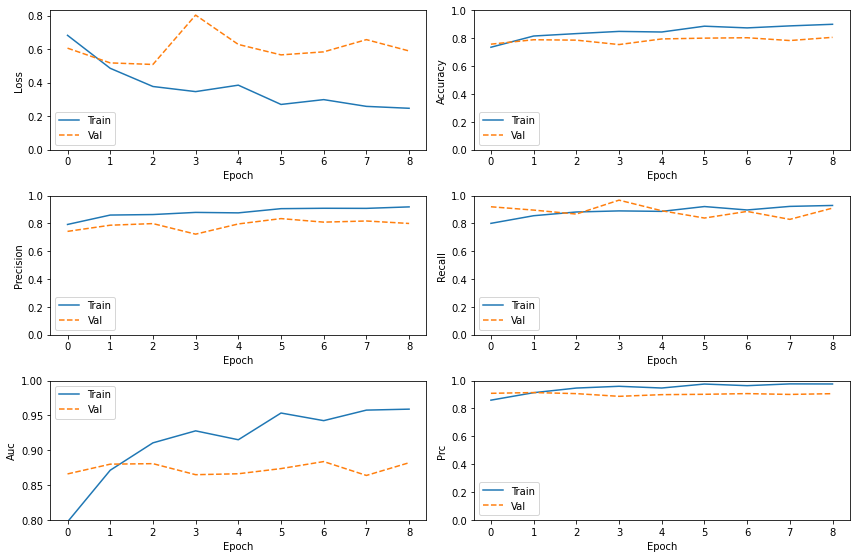

In [38]:
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
plot_metrics(ResNet50v2_tl_history, metrics=metrics_names)
plt.show()

##### Fine-tune the top layers (of the base/pretrained model)

In [40]:
#  unfreeze the base_model
ResNet50v2_pretrained.trainable = True


# set the bottom layers to be un-trainable.
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(ResNet50v2_pretrained.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in ResNet50v2_pretrained.layers[:fine_tune_at]:
  layer.trainable = False

# recompile the model (necessary for these changes to take effect)
# As you are training a much larger model and want to readapt the pretrained weights, 
# it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
ResNet50v2_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/1000),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=metrics)

Number of layers in the base model:  190


In [41]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss',  # for multi-class classification
    monitor='val_prc',  # for binary classification
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [42]:
# resume training
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

ResNet50v2_tl_finetune_history = ResNet50v2_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=ResNet50v2_tl_history.epoch[-1],
    callbacks=[early_stopping],
    class_weight=None)
    # class_weight=class_weight)

Epoch 9/60
44/44 [==============================] - 13s 195ms/step - loss: 0.2526 - accuracy: 0.8692 - precision: 0.8831 - recall: 0.9158 - auc: 0.9383 - prc: 0.9581 - tp: 1012.0000 - fp: 134.0000 - tn: 497.0000 - fn: 93.0000 - val_loss: 0.5155 - val_accuracy: 0.8127 - val_precision: 0.8139 - val_recall: 0.8952 - val_auc: 0.8866 - val_prc: 0.9042 - val_tp: 188.0000 - val_fp: 43.0000 - val_tn: 94.0000 - val_fn: 22.0000
Epoch 10/60
44/44 [==============================] - 7s 155ms/step - loss: 0.1753 - accuracy: 0.9374 - precision: 0.9499 - recall: 0.9531 - auc: 0.9800 - prc: 0.9888 - tp: 853.0000 - fp: 45.0000 - tn: 449.0000 - fn: 42.0000 - val_loss: 0.5085 - val_accuracy: 0.8184 - val_precision: 0.8210 - val_recall: 0.8952 - val_auc: 0.8897 - val_prc: 0.9044 - val_tp: 188.0000 - val_fp: 41.0000 - val_tn: 96.0000 - val_fn: 22.0000
Epoch 11/60
44/44 [==============================] - 7s 155ms/step - loss: 0.1505 - accuracy: 0.9489 - precision: 0.9578 - recall: 0.9631 - auc: 0.9840 - prc:

##### Plot the training performance

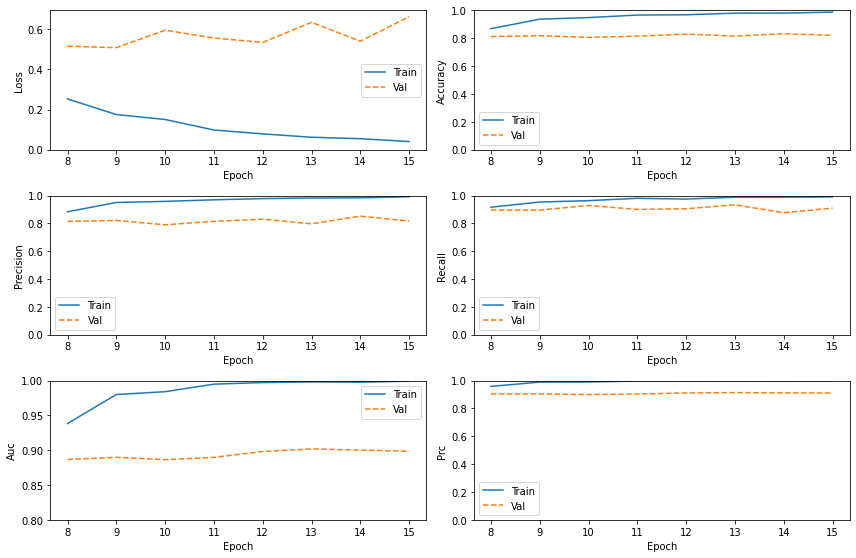

In [43]:
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
plot_metrics(ResNet50v2_tl_finetune_history, metrics=metrics_names)
plt.show()

In [ ]:
# !!! must use test instead of val

train_predictions_baseline = ResNet50v2_tl.predict(train_ds)
val_predictions_baseline = ResNet50v2_tl.predict(val_ds)
print(val_predictions_baseline.shape)

baseline_results = ResNet50v2_tl.evaluate(val_ds, verbose=0)

for name, value in zip(ResNet50v2_tl.metrics_names, baseline_results):
  print(name, ': ', value)
print()

y_true = [tf.argmax(elem[1]).numpy() for elem in val_ds.unbatch()]
# print(y_true)
y_pred = tf.argmax(val_predictions_baseline, axis=1).numpy()
# print(y_pred)

plot_cm(y_true, y_pred)

##### Test the ResNet50 (from scratch)

In [ ]:
preds_scratch = ResNet50_scratch.evaluate(val_ds, verbose=0)

print ("Test Loss = " + str(preds_scratch[0]))
print ("Test Accuracy = " + str(preds_scratch[1]))

##### predict with the ResNet50 (from scratch)

In [ ]:
# define the resize_shape
shape = ResNet50_scratch.input_shape
resize_shape = (shape[1], shape[2])

# define image address
# addr = '/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/76.JPG'
addr = "F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\IMG_6669.JPG"

# prepare an img to be given to the model as input
img_file = Image.open(addr)
img_file_resized = img_file.resize(resize_shape)  # resize the img to the model's input_shape
img_tensor = tf.constant(np.array(img_file_resized))  # PIL ImageFile to TF tensor
img_tensor_norm = tf.cast(img_tensor, tf.float32) / 255.
img_final = tf.expand_dims(img_tensor_norm, axis=0)  # convert (H, W, C) --> (1, H, W, C)
print('img_final shape:', img_final.shape)

# do the prediction (only forward pass)
inference = ResNet50_scratch.predict(img_final, verbose=0)

print('the inference:\n', inference.round(2), sep="")
label = tf.argmax(inference.squeeze()).numpy()  # used .squeeze() since the shape of inference is (1, C)
plt.imshow(img_tensor_norm.numpy())
plt.title(f'predicted label = {label}')
plt.show

#### 3. Comapre ResNet50 (from scratch) vs ResNet50 (pretrained with ImageNet)

In [ ]:
print("ResNet50 (scratch)".center(79, '-'))
print ("Loss = " + str(preds_scratch[0]))
print ("Test Accuracy = " + str(preds_scratch[1]))

print("ResNet50 (pre-trained)".center(79, '-'))
print ("Loss = " + str(preds_pretrained[0]))
print ("Test Accuracy = " + str(preds_pretrained[1]))

plt.bar('ResNet50 (scratch)', preds_scratch[0], width=1)
plt.bar('ResNet50 (pre-trained)', preds_pretrained[0], width=1)
plt.xlabel('Model')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.show()

plt.bar('ResNet50 (scratch)', preds_scratch[1], width=1)
plt.bar('ResNet50 (pre-trained)', preds_pretrained[1], width=1)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

1. although the pretrained ResNet50 has scored slightly lower than the from scratch ResNet50, but:
* the pretrained model was trained with ImageNet but we tested it with sign dataset, so the results are great
* faster (than ResNet50 from scratch) as we didn't spend time training it 
2. if we have the time, computational power and a large dataset to train a model from scratch, then the results would be better (at least slightly)
> but <u>maybe</u> with transfer learning (especially with a small dataset) we can fare better
